### Load datasets

In [1]:
import os
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, exists
from os import makedirs

In [2]:
run_name = "test_model_on_different_datasets"
wandb.init(project="binary_search_optimization", name=run_name)

W&B Run: https://app.wandb.ai/panuthep/binary_search_optimization/runs/t7qzutes

In [3]:
DATASET_HP10K_NUM1K_DIR = "./datasets/dataset_verysmall_hp10000_num1000_balanced.pkl"
DATASET_HP100K_NUM1K_DIR = "./datasets/dataset_verysmall_hp100000_num1000_balanced.pkl"
DATASET_HP10K_NUM10K_DIR = "./datasets/dataset_verysmall_hp10000_num10000_balanced.pkl"
DATASET_HP100K_NUM10K_DIR = "./datasets/dataset_verysmall_hp100000_num10000_balanced.pkl"

WEIGHTS_DIR = join("./save_weights", run_name)
if not exists(WEIGHTS_DIR):
    makedirs(WEIGHTS_DIR)

In [4]:
dataset_hp10k_num1k = pd.read_pickle(DATASET_HP10K_NUM1K_DIR)
dataset_hp100k_num1k = pd.read_pickle(DATASET_HP100K_NUM1K_DIR)
dataset_hp10k_num10k = pd.read_pickle(DATASET_HP10K_NUM10K_DIR)
dataset_hp100k_num10k = pd.read_pickle(DATASET_HP100K_NUM10K_DIR)

### Prepare datasets

In [5]:
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
def prepare_data(dataset, target_col, drop_col=None):
    # Convert target_col to list if it isn't
    if not isinstance(target_col, list):
        target_col = [target_col]
    if drop_col is None:
        drop_col = []
    if not isinstance(drop_col, list):
        drop_col = [drop_col]
        
    # Get input/output vector
    try:
        dataset = dataset.drop(columns=drop_col)
    except:
        pass
    X = dataset.drop(columns=target_col).to_numpy()
    Y = dataset[target_col].to_numpy()
    
    # Normalization
    X_scaler = MinMaxScaler() if not exists(join(WEIGHTS_DIR, "X_scaler.pkl")) else joblib.load(join(WEIGHTS_DIR, "X_scaler.pkl"))
    Y_scaler = MinMaxScaler() if not exists(join(WEIGHTS_DIR, "Y_scaler.pkl")) else joblib.load(join(WEIGHTS_DIR, "Y_scaler.pkl"))
    X = X_scaler.fit_transform(X.astype(np.float32))
    Y = Y_scaler.fit_transform(Y.astype(np.float32))
    
    return X, Y

### Prepare model

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.callbacks import LearningRateScheduler
from utilities import LearningRateFinder, Cosine

In [8]:
wandb.config.network_depth = 1
wandb.config.network_width = 16

In [9]:
class SequenceDense(Model):
    def __init__(self):
        super().__init__()
        self.hidden_layers = []
        for _ in range(wandb.config.network_depth):
            self.hidden_layers.append(Dense(wandb.config.network_width, activation=LeakyReLU()))
        self.output_layer = Dense(1, activation="relu")
        
    def call(self, inputs):
        output = inputs
        for layer in self.hidden_layers:
            output = layer(output)
        output = self.output_layer(output)
        
        return output

In [10]:
model_name = "model_{}_{}".format(wandb.config.network_depth, wandb.config.network_width)

### Prepare test function

In [11]:
def test_func(model, X, Y, plot_name=""):    
    # Caluclate loss distribution
    pred = model.predict(X)
    loss = MAE(Y, pred)
    plt.scatter(Y, loss)
    wandb.log({plot_name: wandb.Image(plt, caption=plot_name)})
    print("Average loss: {}".format(np.mean(loss.numpy())))

### Test on dataset_verysmall_hp10k_num1k

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Average loss: 0.006279016379266977


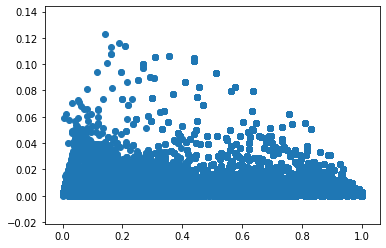

In [12]:
# Get data
X, Y = prepare_data(dataset_hp10k_num1k, target_col="attack_num", drop_col="monster_num")

# Get model
model = SequenceDense()
model.build(input_shape=X.shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mae")

# Load trained weights
model.load_weights(join(WEIGHTS_DIR, "model_trained", model_name))

# Test
test_func(model, X, Y, plot_name="dataset_verysmall_hp10k_num1k")

### Test on dataset_verysmall_hp100k_num1k

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Average loss: 0.013649147003889084


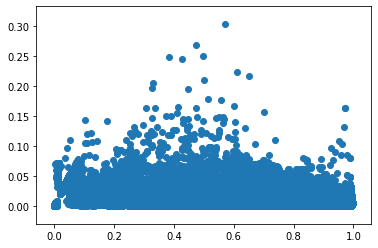

In [13]:
# Get data
X, Y = prepare_data(dataset_hp100k_num1k, target_col="attack_num", drop_col="monster_num")

# Get model
model = SequenceDense()
model.build(input_shape=X.shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mae")

# Load trained weights
model.load_weights(join(WEIGHTS_DIR, "model_trained", model_name))

# Test
test_func(model, X, Y, plot_name="dataset_verysmall_hp100k_num1k")

### Test on dataset_verysmall_hp10k_num10k

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Average loss: 0.057137250900268555


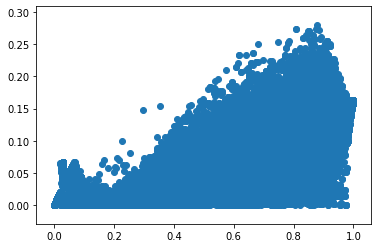

In [14]:
# Get data
X, Y = prepare_data(dataset_hp10k_num10k, target_col="attack_num", drop_col="monster_num")

# Get model
model = SequenceDense()
model.build(input_shape=X.shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mae")

# Load trained weights
model.load_weights(join(WEIGHTS_DIR, "model_trained", model_name))

# Test
test_func(model, X, Y, plot_name="dataset_verysmall_hp10k_num10k")

### Test on dataset_verysmall_hp100k_num10k

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Average loss: 0.059397727251052856


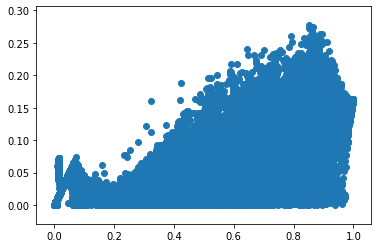

In [15]:
# Get data
X, Y = prepare_data(dataset_hp100k_num10k, target_col="attack_num", drop_col="monster_num")

# Get model
model = SequenceDense()
model.build(input_shape=X.shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mae")

# Load trained weights
model.load_weights(join(WEIGHTS_DIR, "model_trained", model_name))

# Test
test_func(model, X, Y, plot_name="dataset_verysmall_hp100k_num10k")